# Assay and run directory

In [122]:
df = pd.read_csv("/common/workdir/diverse_molecule_generation/datasets/QM9_restricted.csv")
df

,Unnamed: 0,smiles,value,mu
0,0,CN(C)Cc1cnon1,-0.2325,3.9347
1,1,CC1=C(NC=C1)C1CN1,-0.2012,0.8360
2,2,OC1COC11CC1,-0.2270,2.3565
3,3,CC(O)C12CC(C)C1O2,-0.2480,1.4521
4,4,N=COCC1COC1,-0.2531,2.9089
...,...,...,...,...
995,995,CC1OC1(CO)CCO,-0.2575,1.3076
996,996,N=COC1COC11CC1,-0.2384,3.0240
997,997,NC1=NC(O)=CC(=N)O1,-0.2036,5.3596
998,998,[O-]C(=O)C1C2CC(=[NH2+])N12,-0.2661,2.9755


In [123]:
smiles = df.smiles
y = df.value

In [124]:
fps = []
for s in smiles:
    mol = Chem.MolFromSmiles(s)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    fps.append(fp)
    
   # for fp_other in fps_generated:
   #     if DataStructs.FingerprintSimilarity(fp, fp_other)

In [41]:
from rdkit.Chem import DataStructs

In [127]:
sims = []
deltas = []
deltas_mu = []

for i, fp in enumerate(fps):
    for j, fp_other in enumerate(fps):
        sims.append(DataStructs.FingerprintSimilarity(fp, fp_other))
        deltas.append(np.abs(y[i] - y[j]))
        deltas_mu.append(np.abs(df.mu[i] - df.mu[j]))

(array([7.11094e+05, 2.64466e+05, 2.18800e+04, 1.32600e+03, 1.68000e+02,
        5.20000e+01, 4.00000e+00, 2.00000e+00, 0.00000e+00, 1.00800e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

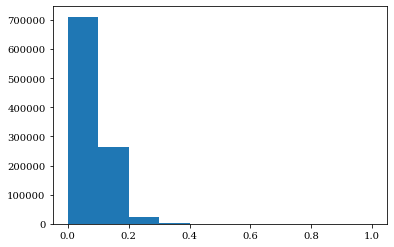

In [46]:
plt.hist(sims)

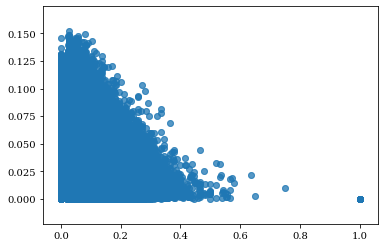

In [128]:
plt.scatter(sims, deltas, alpha=0.5)

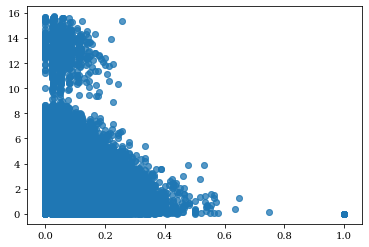

In [129]:
plt.scatter(sims, deltas_mu, alpha=0.5)

(array([240., 414., 245.,  85.,  13.,   2.,   0.,   0.,   0.,   1.]),
 array([ 0.0458,  1.6183,  3.1908,  4.7633,  6.3358,  7.9083,  9.4808,
        11.0533, 12.6258, 14.1983, 15.7708]),
 <a list of 10 Patch objects>)

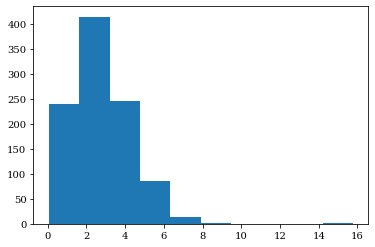

In [130]:
plt.hist(df.mu)

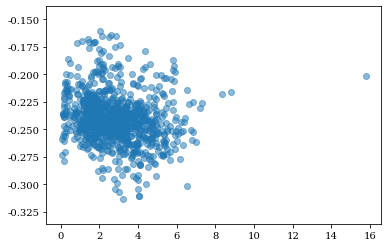

In [145]:
plt.scatter(df.mu, df.value, alpha=0.5)

In [126]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(fps, df.mu)

RandomForestRegressor()

In [1]:
assay_name = "/common/workdir/diverse_molecule_generation/datasets/QM9_restricted.csv"
rundir = "/common/workdir/diverse_molecule_generation/results/lstm_hc/QM9_restricted/"
pca_components = 50
kmeans = True 

results/test/lstm_hc/CHEMBL3888429_cleaned/ecfp4_range_physchem_maxsim_ecfp6/2022-03-17_13:33:05

# Analysis

In [52]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP, MolMR


font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 35,
    'text.usetex': False,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline 

In [53]:
scores_test, smiles_test, activities_test, clf = data_split(assay_name)

In [54]:
os.listdir(rundir)

['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.25',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.3']

In [87]:
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []

l = ['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.3',
 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.3']

for directory in l:
    smiles = []
    scores = []
    trajectories = []
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(os.path.join(rundir, directory, result_dir, 'results.json'), 'r') as f:
                results = json.load(f)
                smiles.extend([row['smiles'] for row in results['statistics']][-1])
                scores.extend([row['preds']['scores'] for row in results['statistics']][-1])
                #trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                average_trajectories = np.array([np.mean(row['preds']['scores']) for row in results['statistics']])
        except:
            pass
    if len(smiles)>0:
        runs.append(directory)
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)


In [88]:
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i])==1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)


In [89]:
X = np.array(actives + inactives)
#clustering = DBSCAN(eps=0.25, min_samples=1, metric='jaccard', p=1).fit(X)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_

In [90]:
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)

In [91]:
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [92]:
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    
for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)
    

In [93]:
pca = PCA(n_components=2).fit(np.concatenate((fps_inactive_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [94]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [95]:
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()

In [96]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

In [97]:
# Parameters for drawing an ellipse around the main cluster
quant=0.1
n=80
t = np.linspace(0,2*np.pi,n)
l = 1.4 # Factor for considering only the generated structures that are far from the main cluster

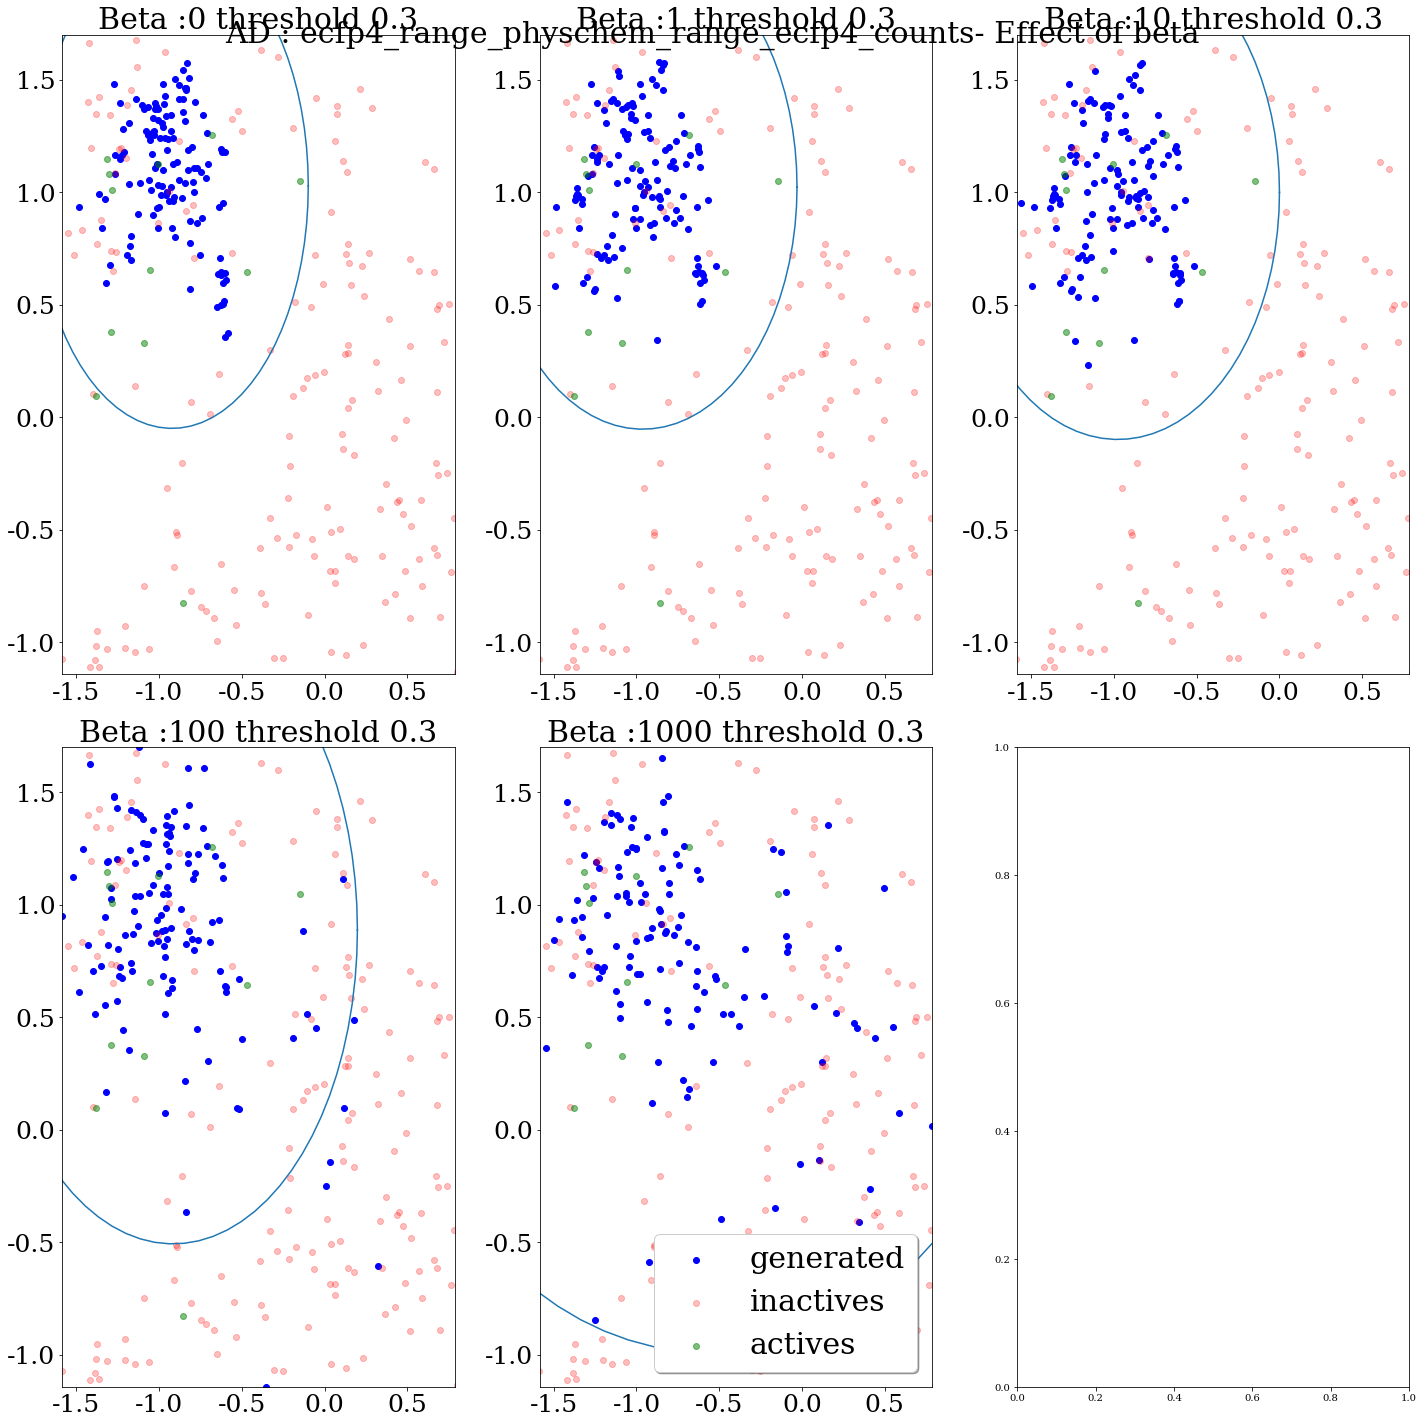

In [98]:
runs_to_display = runs
#runs_to_display = runs 
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs_to_display)/3)) , ncols=3)
suptitle_tmp = 'AD : ' + runs_to_display[0].split('_beta_ ')[0] + '- Effect of beta'
fig.suptitle(suptitle_tmp, fontsize=30)


for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    pca_gen = pca_generated[index]
    # For displaying the ellipse arounfd the main cluster
    [x_min,x_max] = [np.quantile(pca_gen[:,0:1], quant),np.quantile(pca_gen[:,0:1], 1.0-quant)]
    [y_min,y_max] = [np.quantile(pca_gen[:,1:2], quant),np.quantile(pca_gen[:,1:2], 1.0-quant)]
    center_x = np.mean([x_max,x_min])
    center_y = np.mean([y_max,y_min])
    radius_x = l*(x_max-x_min)
    radius_y = l*(y_max-y_min)
    #
    ax = axs.flatten()[i]
    run_title_tmp = run.split('_beta_ ')[1]
    run_title = 'Beta :' + run_title_tmp
    ax.set_title(run_title.replace('_', ' '), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c='b', label = 'generated', alpha=1)
    ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.5)
    # Proximity ellipse
    ax.plot( center_x+radius_x*np.cos(t) , center_y+radius_y*np.sin(t) )
    #
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    if i==len(runs_to_display)-1: 
        ax.legend(loc='lower right',
              ncol=1, fancybox=True, shadow=True, fontsize=30)
    
fig.tight_layout(pad=1.5)
#plt.savefig('images/JAK2/PCA.png', dpi=300)   

In [99]:
distant_smiles_dict = {}
for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    smiles_generated = smiles_list[i]
    pca_gen = pca_generated[index]
    [x_min,x_max] = [np.quantile(pca_gen[:,0:1], quant),np.quantile(pca_gen[:,0:1], 1.0-quant)]
    [y_min,y_max] = [np.quantile(pca_gen[:,1:2], quant),np.quantile(pca_gen[:,1:2], 1.0-quant)]
    center_x = np.mean([x_max,x_min])
    center_y = np.mean([y_max,y_min])
    radius_x = 1.4*(x_max-x_min)
    radius_y = 1.4*(y_max-y_min)
    is_distant = [((x-center_x)**2/radius_x**2+(y-center_y)**2/radius_y**2 > 1.0) for x,y in zip(list(pca_gen[:,0:1].ravel()),list(pca_gen[:,1:2].ravel()))]
    is_distant_indexes =[i for i, x in enumerate(is_distant) if x]
    distant_smiles_dict[run] = [ smiles_generated[i] for i in is_distant_indexes]

In [101]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in distant_smiles_dict['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.3']],molsPerRow=6)

In [102]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in distant_smiles_dict['ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.3']],molsPerRow=6)

In [103]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in distant_smiles_dict['ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.3']],molsPerRow=6)

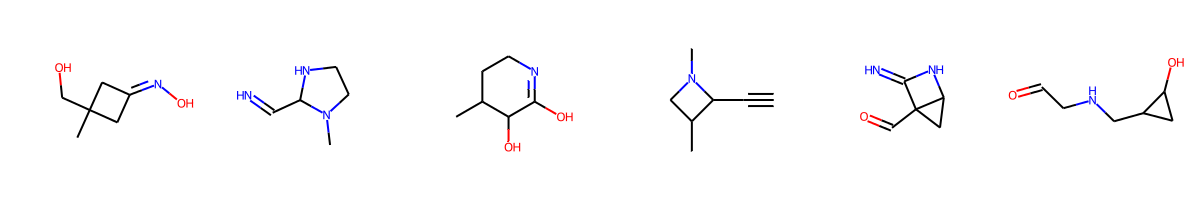

In [104]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in distant_smiles_dict['ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.3']],molsPerRow=6)

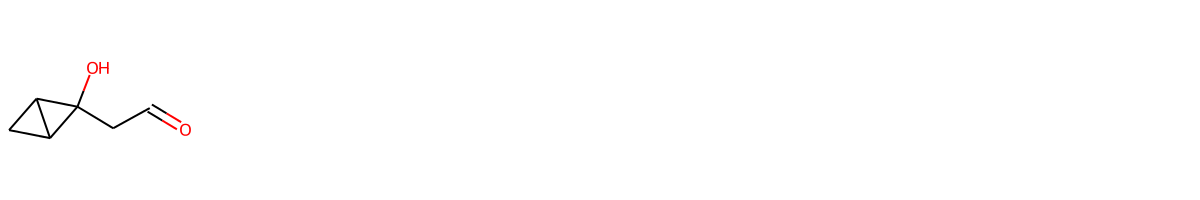

In [105]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in distant_smiles_dict['ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.3']],molsPerRow=6)

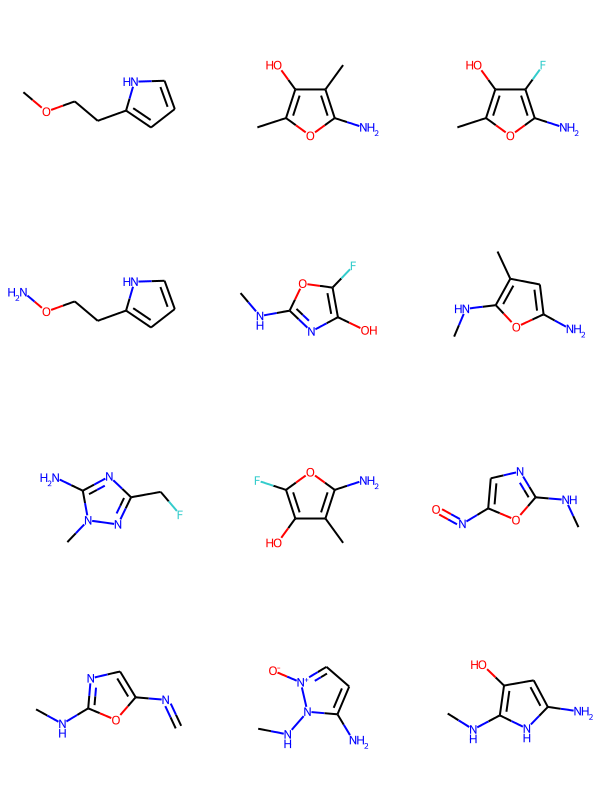

In [144]:
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles_list[-1][:12]])

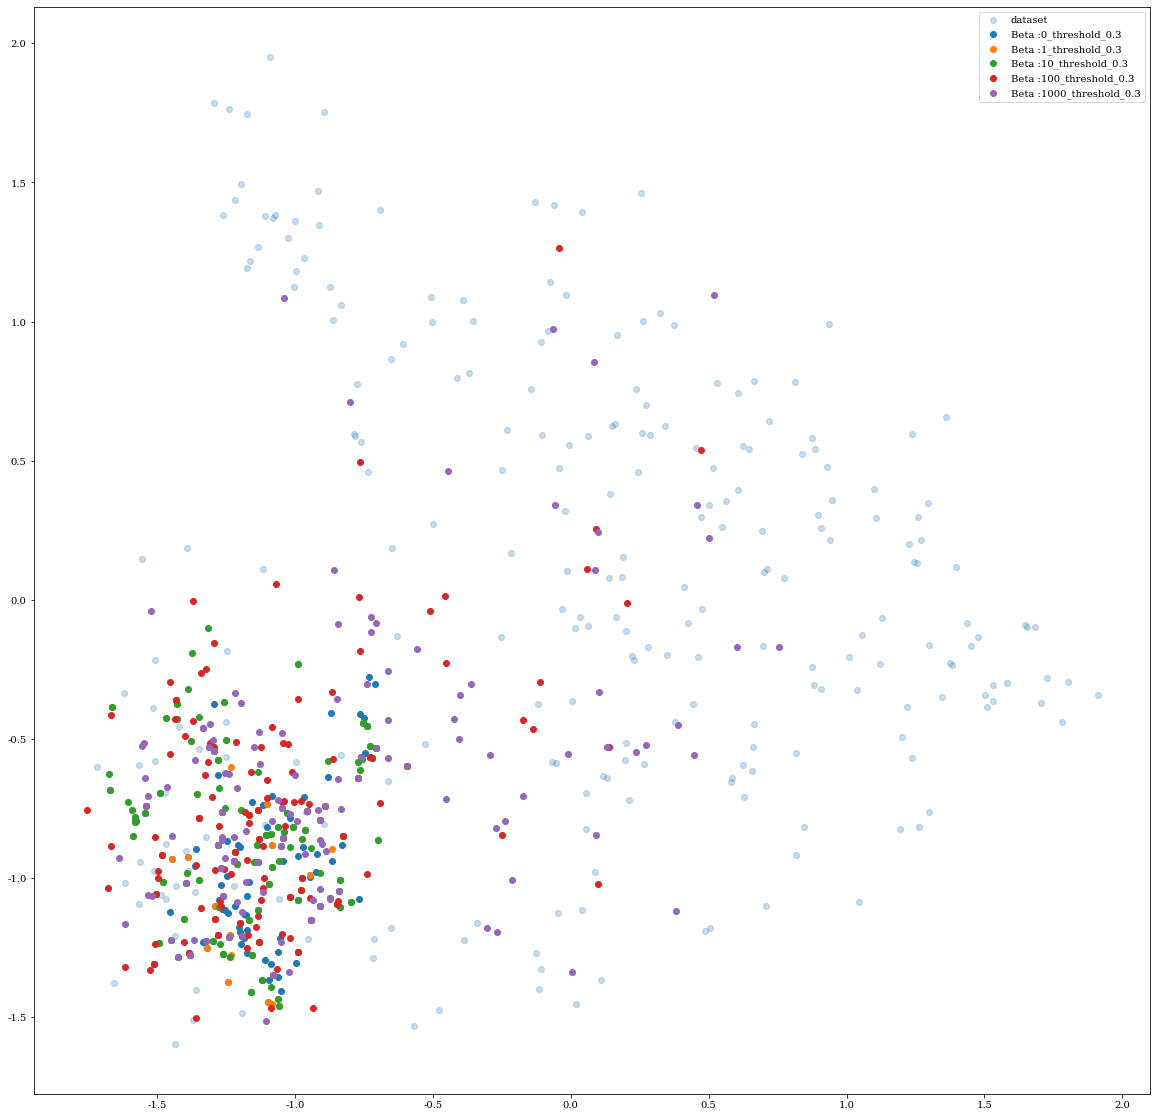

In [106]:
fps = []
for s in smiles_test:
    mol = Chem.MolFromSmiles(s)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    
plt.figure(figsize=(20, 20))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

validity = []

    
for s in smiles_test:
    mol = Chem.MolFromSmiles(s)
    fp = ecfp4([s])[0].reshape(1, -1)
    prediction = clf.predict_proba(fp)[0, 1]
    validity.append(prediction) 

plt.scatter(X_pca[:, 0], X_pca[:, 1], label='dataset', alpha=0.25)

for i, run in enumerate(runs):
    X_generated = []
    run_title_tmp = run.split('_beta_ ')[1]
    run_title = 'Beta :' + run_title_tmp
    for s in smiles_list[i]:
        mol = Chem.MolFromSmiles(s)
        X_generated.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    X_transformed = pca.transform(X_generated)
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors[i], label=run_title)

#plt.colorbar()

plt.legend()

In [107]:
pca_generated = []
entropies = []
clusters = []
    
pca = PCA(n_components=2).fit(np.concatenate((fps_active_as_array,fps_inactive_as_array)))
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1]>0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]    
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)  
    else:
        curr_clusters = [find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(len(np.where(np.array(curr_clusters)==i)[0])/len(curr_clusters))
    entropy = scipy.stats.entropy(probs)/ np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [108]:
xmin_ymin = np.amin(np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0).tolist()
xmax_ymax = np.amax(np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

Text(0.5, 1.05, 'PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives')

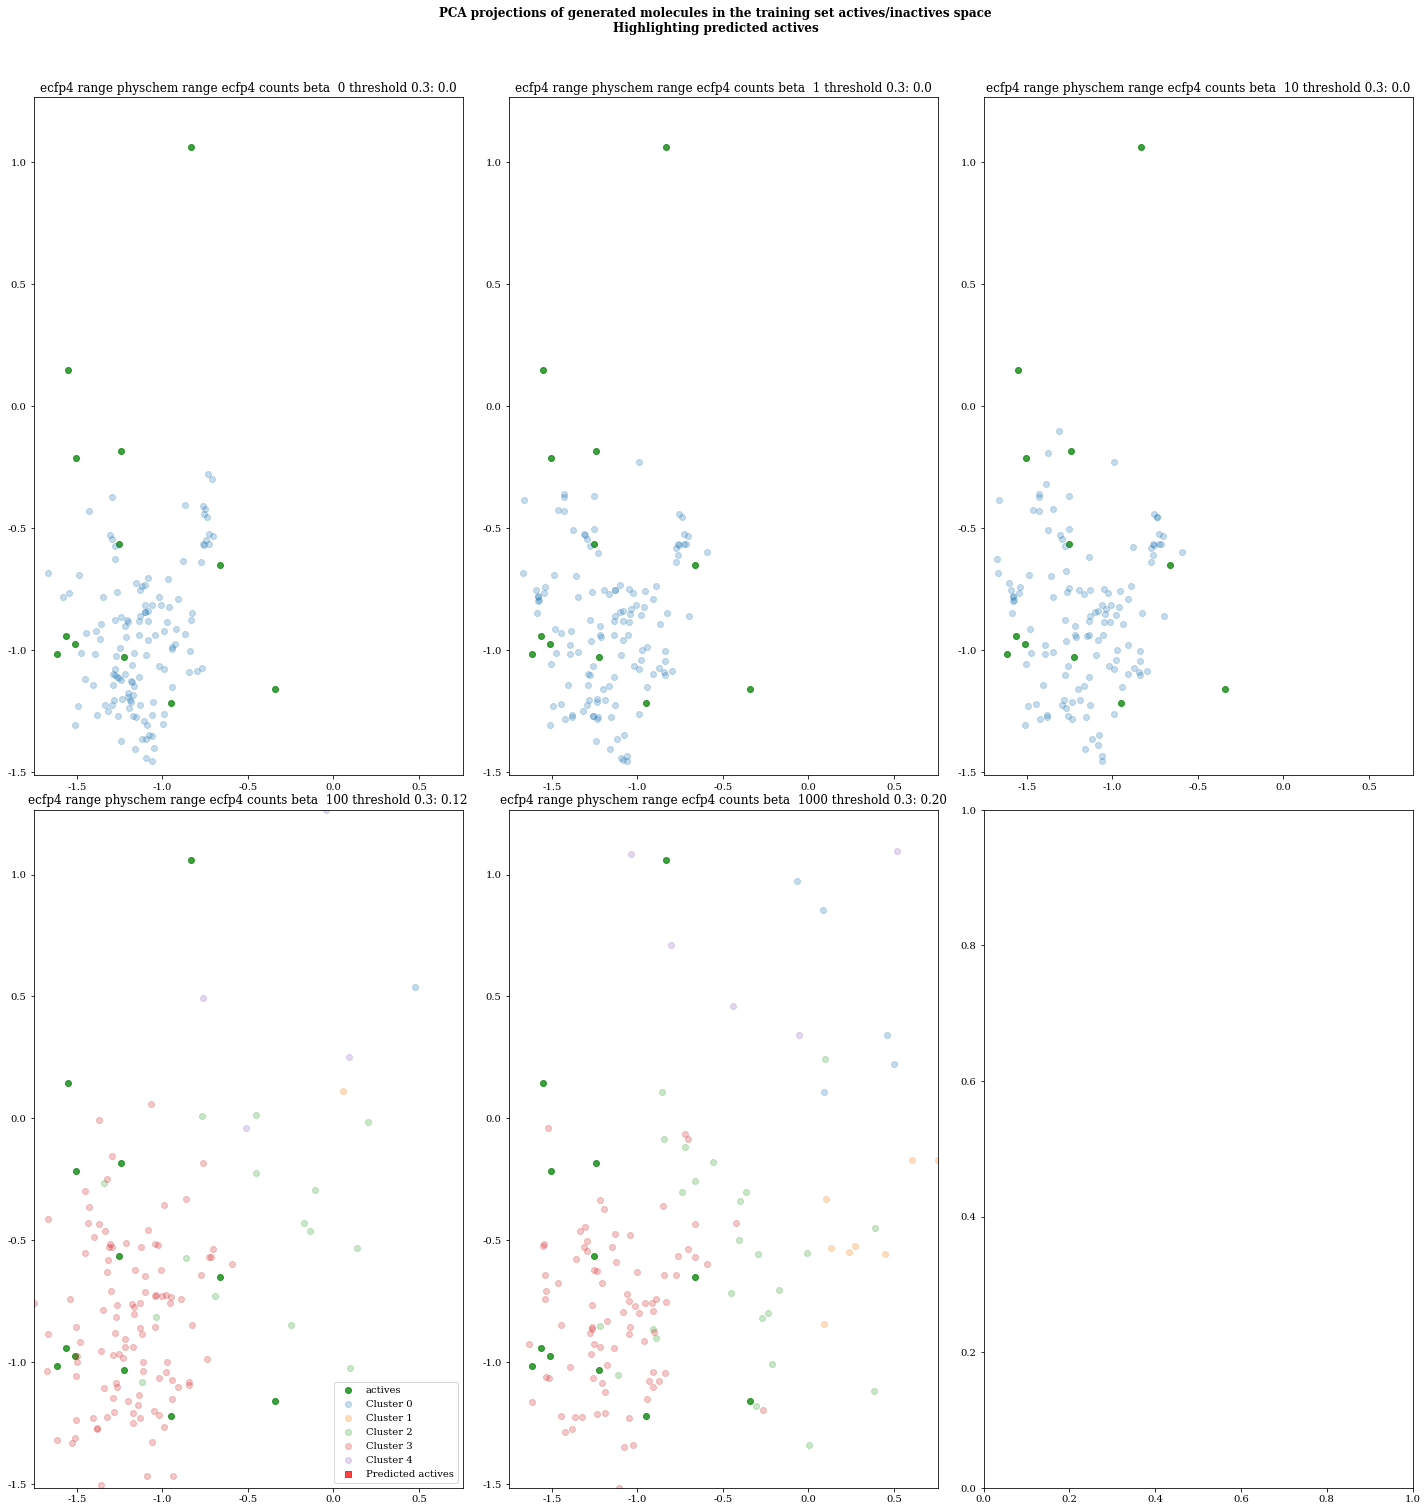

In [109]:
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3)
fig.tight_layout(pad=1.5)
no_legend = 0

for i, run in enumerate(runs):
    curr_clusters = clusters[i]
    entropy = entropies[i]
    pca_gen = pca_generated[i]
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' ') + ': ' + str(entropy)[:4])
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c='g', label = 'actives', alpha=0.75)    
    for c in np.unique(curr_clusters):
        ax.scatter(pca_gen[:, 0][np.where(curr_clusters==c)], pca_gen[:, 1][np.where(curr_clusters==c)], label= 'Cluster ' + str(c), alpha=0.25)    

    ax.scatter(pca_active[predicted_actives, 0], pca_active[predicted_actives, 1], c='r', label = 'Predicted actives', alpha=0.75, marker='s')
    #ax.scatter(pca_inactive[:, 0], pca_inactive[:, 1], c='r', label = 'inactives', alpha=0.25)
    if len(np.unique(curr_clusters)) == np.amax([len(set(c)) for c in clusters]) and  no_legend == 0 :
        ax.legend(loc=4)
        no_legend = 1
fig.suptitle('PCA projections of generated molecules in the training set actives/inactives space\nHighlighting predicted actives',fontweight ="bold", y=1.05)    

In [110]:
qed_dataset = []
sas_dataset = []
for s in smiles_actives + smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    qed_dataset.append(Descriptors.qed(mol))
    sas_dataset.append(calculateScore(mol))

In [111]:
QED = []
SAS = []

SAS_for_results = []
QED_for_results = []
ad = []
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    qed_generated = []
    sas_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        qed_generated.append(Descriptors.qed(mol))
        sas_generated.append(calculateScore(mol))

    
        
        QED.append(Descriptors.qed(mol))
        SAS.append(calculateScore(mol))
        ad.append(run)
    SAS_for_results.append(sas_generated)
    QED_for_results.append(qed_generated)

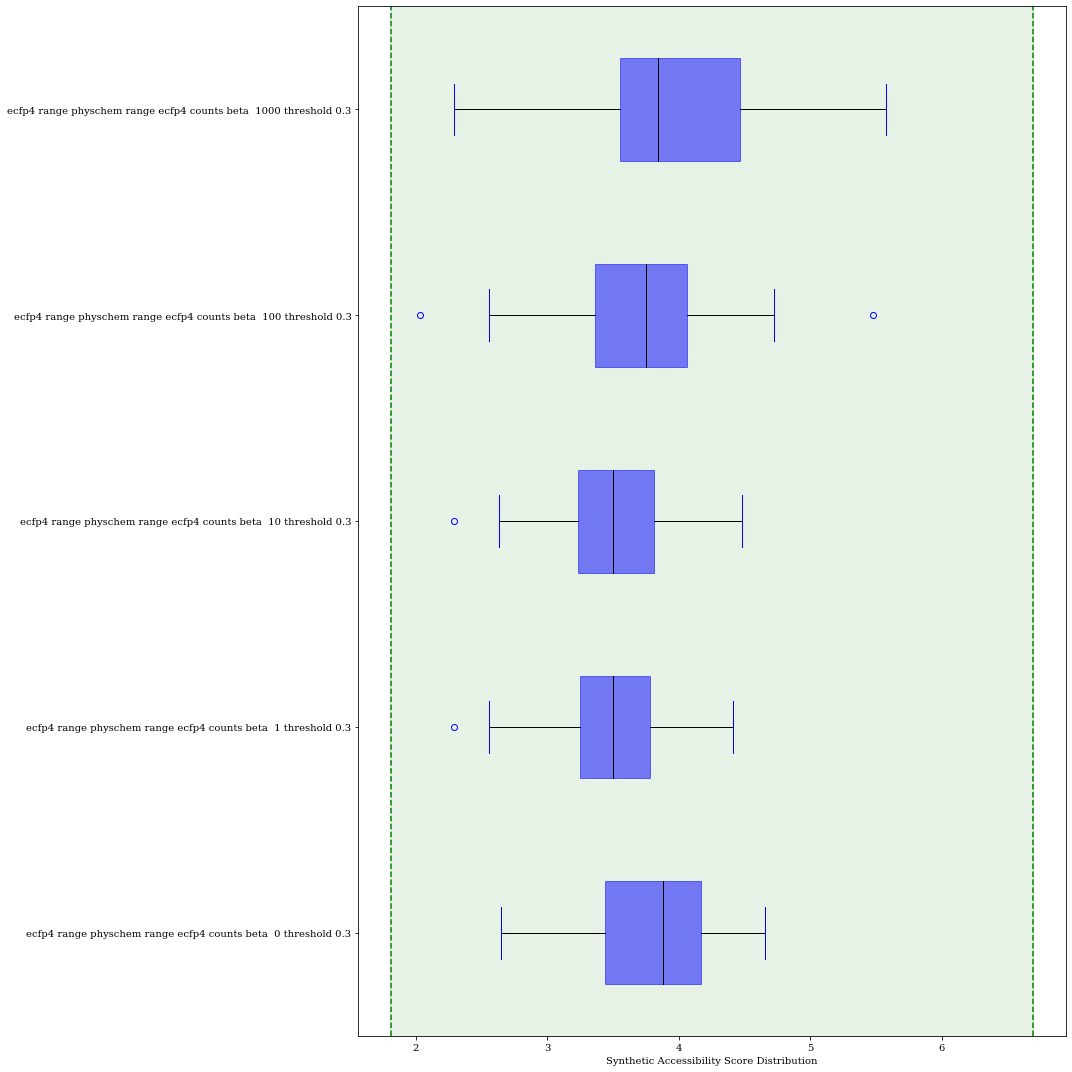

In [112]:

plt.figure(figsize= (15, 15))
#display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
#chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
#['$' + str(x) + '$' for x in runs]
c = 'blue'
box = plt.boxplot(SAS_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



#plt.boxplot(QED, vert=False)
#plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(np.percentile(sas_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(sas_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(sas_dataset, 0), np.percentile(sas_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
#plt.legend(loc=4)
plt.xlabel("Synthetic Accessibility Score Distribution")
#plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
#plt.savefig('images/JAK2/SAS_distribution.png', dpi=300)

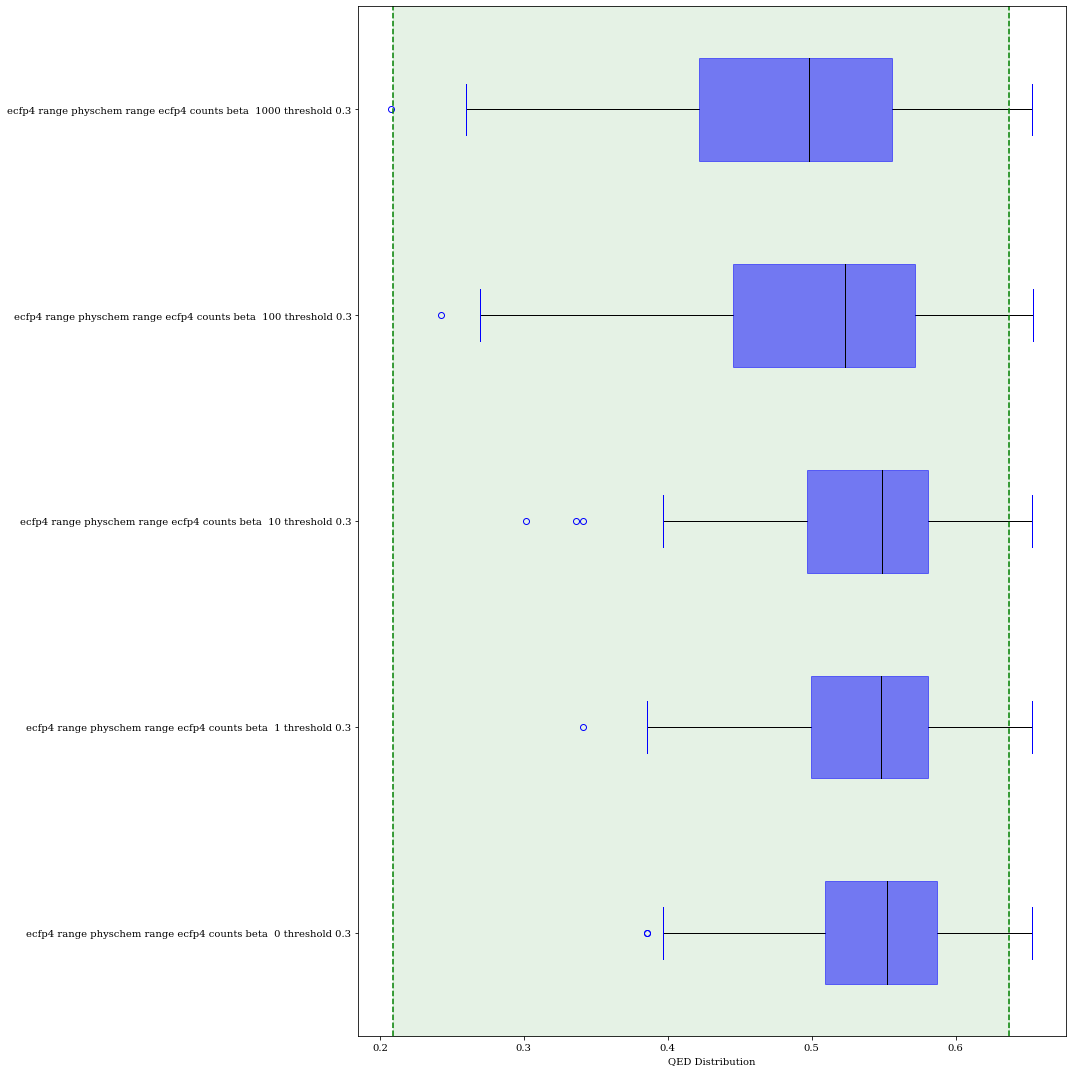

In [113]:
plt.figure(figsize= (15, 15))
#display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
#chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
#['$' + str(x) + '$' for x in runs]
c = 'blue'
box = plt.boxplot(QED_for_results, labels = [x.replace('_', ' ') for x in runs], vert=False, patch_artist=True,
            boxprops=dict(facecolor=c, color=c, alpha=0.5),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'),)



#plt.boxplot(QED, vert=False)
#plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(np.percentile(qed_dataset, 100), ls='--', label='Dataset extreme QED values', c='g')
plt.axvline(np.percentile(qed_dataset, 0), ls='--', c='g')
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between([np.percentile(qed_dataset, 0), np.percentile(qed_dataset, 100)], ymin, ymax, color='g', alpha=0.1, label = 'Valid QED')
#plt.legend(loc=4)
plt.xlabel("QED Distribution")
#plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
#plt.savefig('images/JAK2/QED_distribution.png', dpi=300)

# Comparing different AD's outputs

In [114]:
from utils import qualitative_analysis, return_distribution_cycle_size, return_distribution_mw, return_distribution_halogen, return_distribution_heteroatoms, return_distribution_radicals, return_distribution_sulphur, qualitative_analysis

In [115]:
average_similarities = []
max_similarities = []
common_molecules = {}
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    fps_generated = fps_generated_as_bitv[i]
    for j, comparison_run in enumerate(runs):
        smiles_generated = smiles_list[j]
        fps_other = fps_generated_as_bitv[j]
        if j<i:
            indexes, indexes_other = indexes_identical_fps(fps_generated, fps_other)
            common_molecules[run + '_vs_' + comparison_run] = [indexes, indexes_other] 
        avg_sims.append(average_tanimoto_similarity(fps_generated, fps_other))
        max_sim.append(max_tanimoto_similarity(fps_generated, fps_other))
    average_similarities.append(avg_sims)
    max_similarities.append(max_sim)

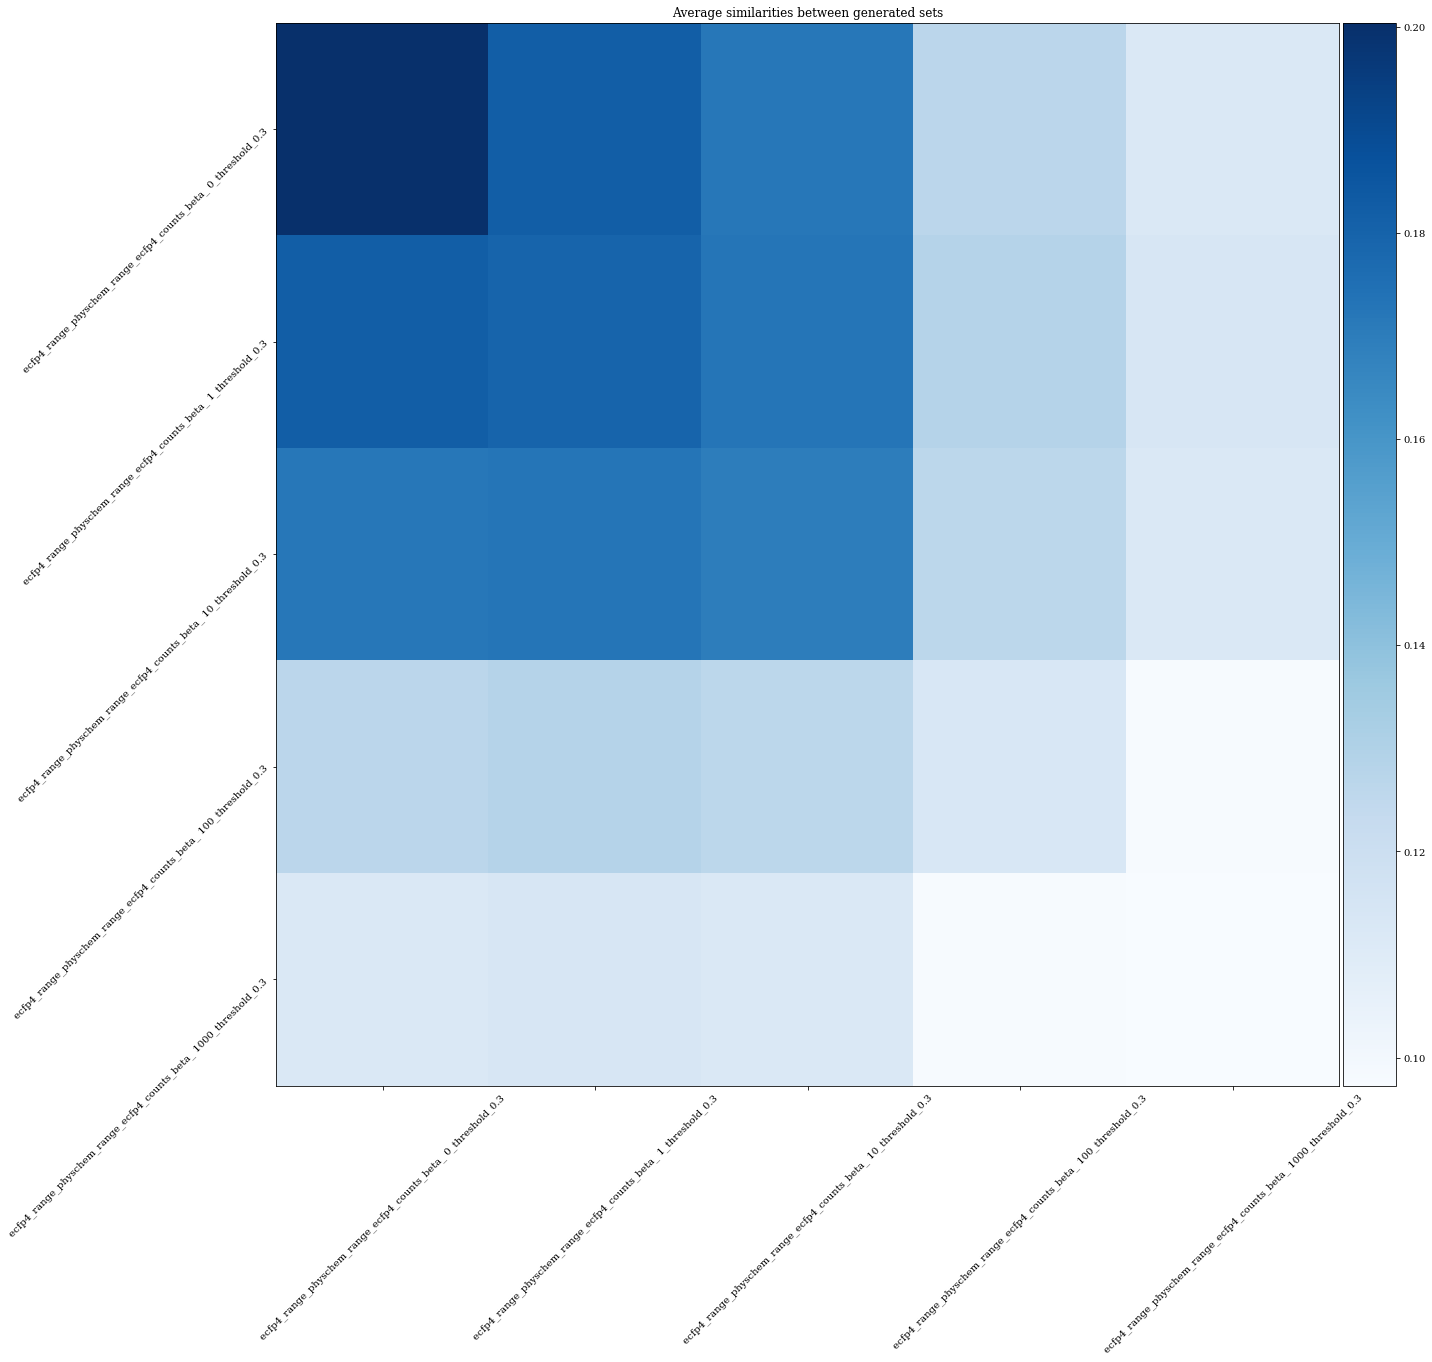

In [116]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = runs

fig, ax = plt.subplots(figsize = (20, 20), nrows=1 , ncols=1)

fig.tight_layout(pad=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



ax.set_title("Average similarities between generated sets")

im = ax.imshow(np.array(average_similarities), cmap='Blues')
ax.set_yticks(ticks=range(len(runs)))
ax.set_xticks(ticks=range(len(runs)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels, rotation=45)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
#plt.colorbar()
fig.tight_layout(pad=3.0)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.grid(False)

plt.tight_layout()
#plt.savefig('images/JAK2/similarities.png', dpi=300)

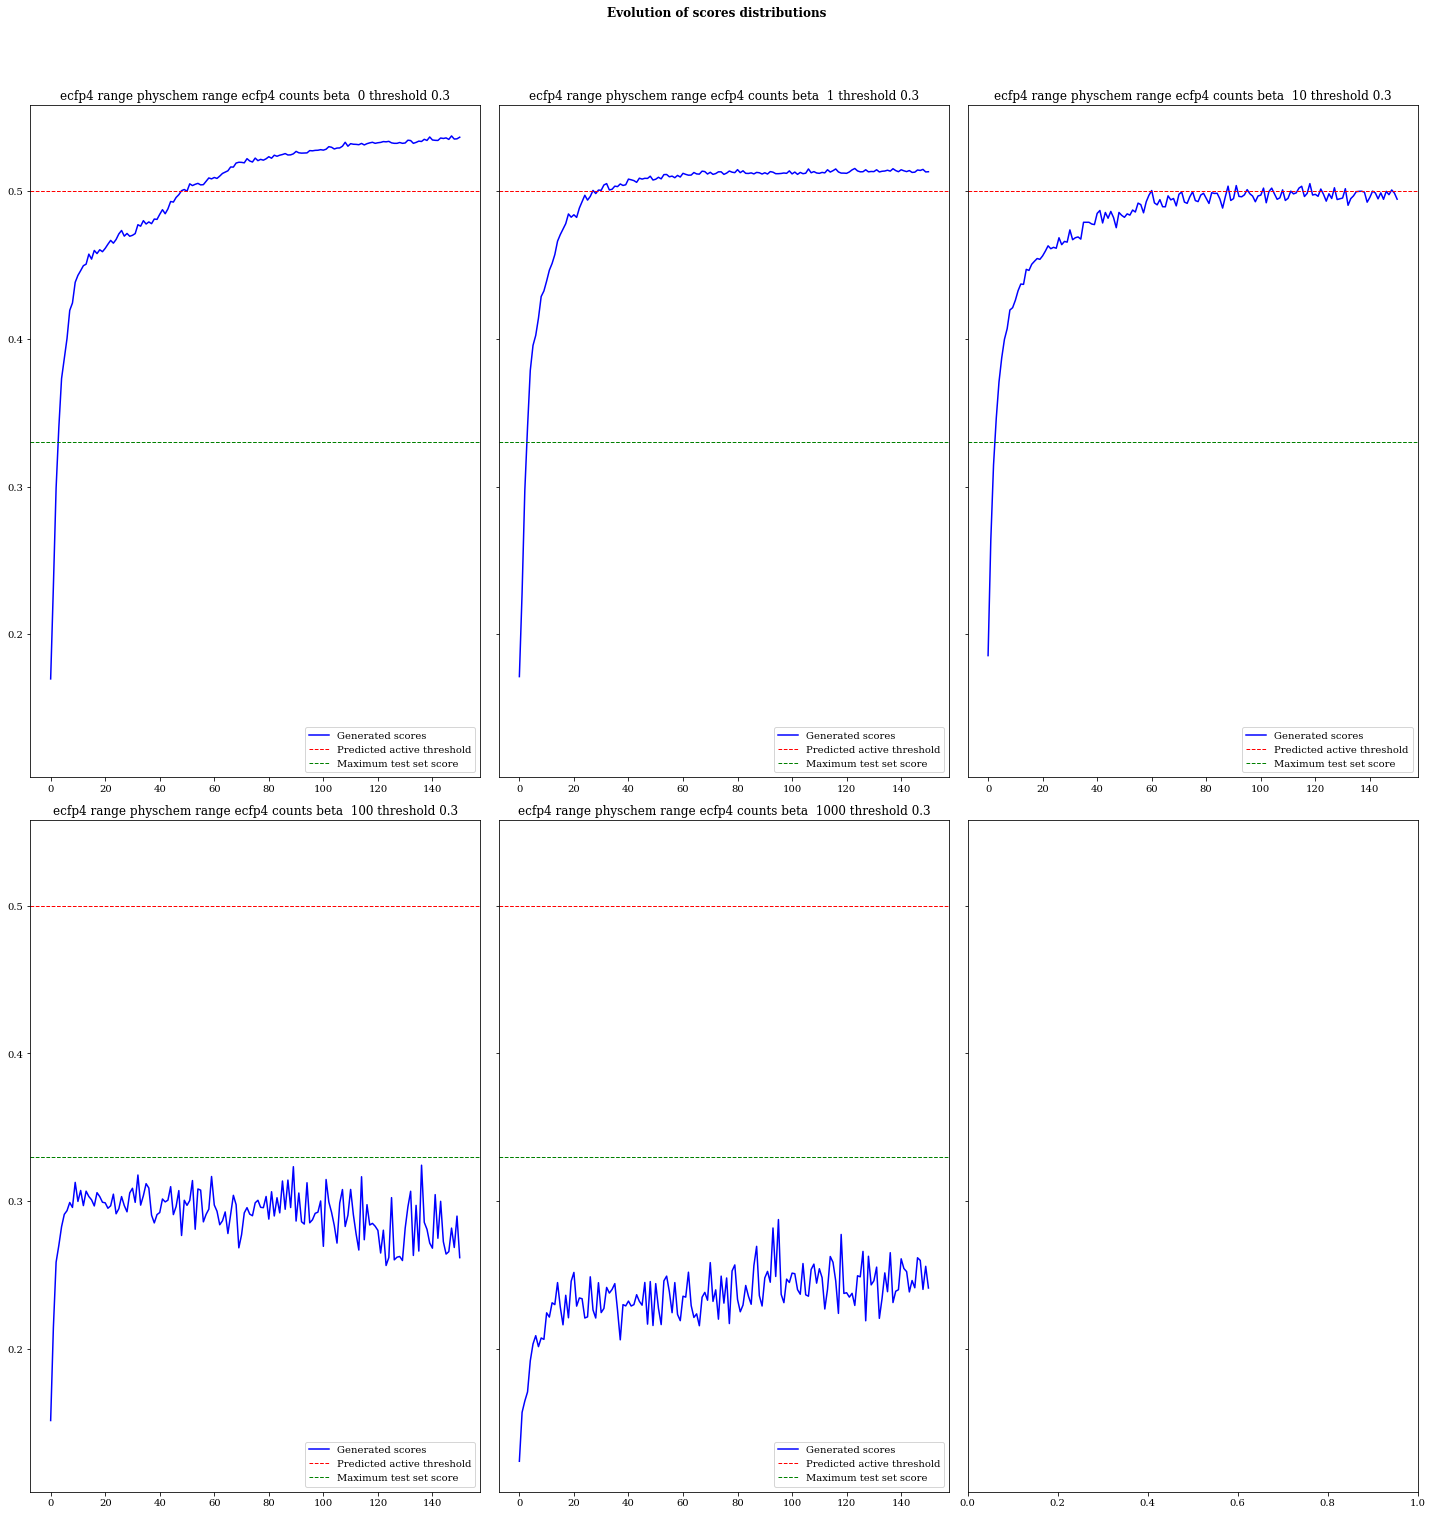

In [117]:
fig, axs = plt.subplots(figsize = (20, 20), nrows=max(1, math.ceil(len(runs)/3)) , ncols=3, sharey=True)

fig.tight_layout(pad=1.5)

for i, run in enumerate(runs):
    ax = axs.flatten()[i]
    ax.set_title(run.replace('_', ' '))
    scores = np.array(scores_trajectories[runs.index(run)])
    """
    median = np.median(scores, 1)
    q25 = np.percentile(scores, 5, axis=1)
    q75 = np.percentile(scores, 95, axis=1)
    ax.plot(median, c='b', label='Generated scores')
    ax.fill_between(
        np.arange(median.shape[0]), q25, q75, alpha=.1, color='b')
    """
    ax.plot(scores, c='b', label='Generated scores')
    ax.axhline(y=0.5, linewidth=1, ls='--', color='r', label='Predicted active threshold')
    ax.axhline(y=np.max(scores_test), linewidth=1, ls='--', color='g', label='Maximum test set score')
    ax.legend(loc=4)
fig.suptitle('Evolution of scores distributions', fontweight ="bold", y=1.05)
plt.tight_layout()

# Additional functions

In [131]:
import random 
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(3):
    print(seed)
    np.random.seed(seed)
    """
    length = np.random.uniform(1, 2)
    
    threshold_low_clogp_random = np.random.uniform(0, 5)
    threshold_low_clogp = random.choice([threshold_low_clogp_random, 7])
    threshold_low_clogp = random.choice(logp_test) -length/2
    threshold_high_clogp = threshold_low_clogp + length/2
    

    length = np.random.uniform(10, 15)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = threshold_low_tpsa_random
    #threshold_low_tpsa = random.choice([threshold_low_tpsa_random, threshold_low_tpsa_random, 140])
    #threshold_low_tpsa = np.random.uniform(70, 130)
    threshold_high_tpsa = threshold_low_tpsa + length
    """
    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"
    
    """
    smiles_valid = np.random.choice(smiles_test, 100)
    fp_valid = []
    for s in smiles_valid:
        fp_valid.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    """
    """
    #smiles_generated = np.random.choice(smiles_augmented, 3000)
    ground_truth = []
    smiles_generated = smiles_list[j]
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fp = ecfp4([s])[0].reshape(1, -1)
        prediction = clf.predict_proba(fp)[0, 1]
        #prediction = np.random.binomial(prediction, 1)
        ground_truth.append(prediction)
    """    
    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.3]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []
                    
                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)


                    scores = [] 
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)).reshape(1, -1)
                        additional = 1 * clustering.predict(fp)[0]==cluster
                        scores_additional.append(additional)
                        scores.append(additional*prediction) 
                        
                        scores_prediction.append(prediction)
                    if np.sum(scores)==0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

0
1
2


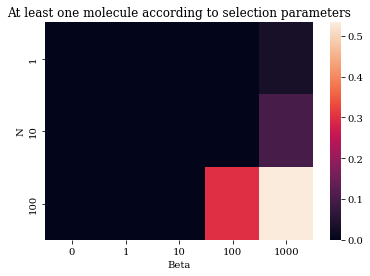

In [132]:
display_df = pd.DataFrame(zip(joint_scores, logp_scores, optimisation_scores,  at_least_one, lcorr_list, beta_list, n_smiles_list), columns =['Average score', 'Additional score', 'Optimization score', 'At least one', "Length of correlation", 'Beta', 'N'])
plt.title("At least one molecule according to selection parameters")
pivoted = display_df.groupby(["Beta", "N"]).mean().reset_index().pivot("N", "Beta", "At least one")
sns.heatmap(pivoted)

In [135]:
logps = []

for l in smiles_list:
    current_logp = []
    for s in l:
        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)).reshape(1, -1)
        current_logp.append(reg.predict(fp))
    logps.append(current_logp)
    
logp_test = []
for s in np.array(smiles_actives + smiles_inactives):
    fp = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)).reshape(1, -1)
    logp_test.append(reg.predict(fp))

In [137]:
def is_valid_mu(s, threshold_low_mu=0, threshold_high_mu=2):
    mol = Chem.MolFromSmiles(s)
    fp = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2)).reshape(1, -1)
    mu = reg.predict(fp)
    return mu>=threshold_low_mu and mu<=threshold_high_mu

In [141]:
import random 
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(5):
    print(seed)
    np.random.seed(seed)
    
    length = np.random.uniform(0.5, 0.75)
    
    threshold_low_mu = random.choice(logp_test) -length/2
    threshold_high_mu = threshold_low_mu + length/2
    
    cluster = random.choice(range(5))

    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.3]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []
                    
                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)


                    scores = [] 
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)).reshape(1, -1)
      
                        scores_additional.append(is_valid_mu(s,threshold_low_mu, threshold_high_mu))
                        scores.append(is_valid_mu(s,threshold_low_mu, threshold_high_mu)*prediction) 
     
                        scores_prediction.append(prediction)
                    if np.sum(scores)==0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

0
1
2
3
4


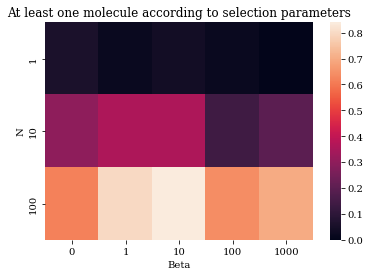

In [142]:
display_df = pd.DataFrame(zip(joint_scores, logp_scores, optimisation_scores,  at_least_one, lcorr_list, beta_list, n_smiles_list), columns =['Average score', 'Additional score', 'Optimization score', 'At least one', "Length of correlation", 'Beta', 'N'])
plt.title("At least one molecule according to selection parameters")
pivoted = display_df.groupby(["Beta", "N"]).mean().reset_index().pivot("N", "Beta", "At least one")
sns.heatmap(pivoted)

In [ ]:
# Minimiser GAP Homo-Lumo 
# 3 eV 
# Passer à 10 000 + faire homo-lumo 